In [1]:
# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1, as_frame=False) # as_frame이 True일 경우 DataFrame 타입으로 변환됨 -> 오류
mnist.keys()

#사이킷런에서 읽어 들인 데이터셋들은 일반적으로 비슷한 딕셔너리 구조를 갖고 있음
#1 데이터셋을 설명하는 DESCR키
#2 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data키
#3 레이블 배열을 담은 target 키

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
#배열 살펴보기

X, y = mnist["data"], mnist["target"]

In [4]:
X.shape

#이미지 = 70000개, 각 이미지에 784개의 특성(28 * 28)

(70000, 784)

In [5]:
y.shape

(70000,)

그림 저장: some_digit_plot


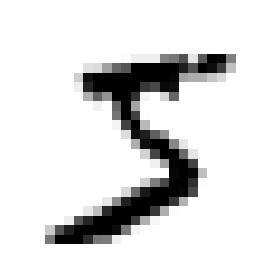

In [6]:
#데이터셋에서 이미지 확인

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [7]:
#실제 레이블

y[0]

'5'

In [8]:
#레이블이 문자열이기 때문에 편의를 위해 정수로 변환함

y = y.astype(np.uint8)

In [9]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [10]:
#훈련 세트, 테스트 세트 분리하기
#MNIST 뎅터셋은 앞쪽 60000개(훈련), 뒤쪽 100000개(테스트) 이미지로 나눠져있음

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

#데이터셋을 섞어 알고리즘의 성능을 더욱 좋게할 수 있음(위 훈련세트는 이미 섞여있음)

In [11]:
#이진 분류기 훈련

#숫자 5 식별하기
#5-감지기 (5와 5아님으로 분류)

#분류 작업을 위한 타깃 벡터 생성

y_train_5 = (y_train == 5) #5 이외 모두 false, 5는 true
y_test_5 = (y_test == 5)

In [12]:
#확률적 경사 하강법 분류기로 훈련시키기

#SGDClassifier = 매우 큰 데이터셋을 효율적으로 처리(한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42) #훈련하는데 무작위성을 사용하기 때문에 결과 재현을 위해 random_state 매개변수 지정
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [13]:
#위의 모델을 사용해 숫자 5 감지하기

sgd_clf.predict([some_digit])

#5를 나타낸다고 추측함(결과가 True)

array([ True])

In [14]:
#모델 성능 평가하기

#①교차 검증

#StratifiedKFold를 활용한 교차 검증 구현하기
#사이킷런의 cross_val_score()과 거의 같은 작업 수행, 동일한 결과 출력하는 코드

#StratifiedKFold = target에 속성값의 개수를 동일하게 가져감으로써 데이터가 한 곳으로 몰리는 것을 방지

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf) #매 반복에서 분류기 객체 복제
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds) #훈련 폴드로 훈련
    y_pred = clone_clf.predict(X_test_fold) #테스트 폴드로 예측
    n_correct = sum(y_pred == y_test_fold) #정확히 예측된 경우
    print(n_correct / len(y_pred)) #정확한 예측의 비율 출력

0.9669
0.91625
0.96785


In [15]:
#k-겹 교차 검증을 사용해 SGDClassifier 모델 평가

from sklearn.model_selection import cross_val_score

#3개의 폴드로 나누고(cv=3) 훈련시킨 후 모델의 정확도 점수 구하기
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [16]:
#모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기 생성

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

#불균형한 데이터셋을 다룰 때 결과값이 달라지기 때문에 정확도를 분류기의 성능 측정 지표로 선호하지 않음

array([0.91125, 0.90855, 0.90915])

In [18]:
#②오차 행렬
#클래스 A의 샘플이 클래스 B로 분류된 횟수 세기

#실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 함
#테스트세트는 프로젝트의 맨 마지막에 사용되는 것이기 때문에 예측을 만들 때 사용하면 안됨

#cross_val_predict() = 예측값 구하기

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [19]:
#오차 행렬 만들기

# 5, 5아님 2*2 행렬 생성됨

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [20]:
#완벽한 오차 행렬의 예

y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [21]:
#양성 예측의 정확도 => 분류기의 "정밀도"
#정밀도: TP / TP + FP
#정밀도 하나로는 다른 모든 양성 샘플을 무시하기 때문에 유용하지 않음 -> "재현율" 사용

#재현율 = 분류기가 정확하게 감지한 양성 샘플의 비율 = TP / TP + FN (민감도 / 진짜 양성 비율이라고도 부름)

#presision_score = 정밀도 / recall_score = 재현율

from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1522)

0.8370879772350012

In [22]:
recall_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1325)

0.6511713705958311

In [23]:
#F1 점수
# -> 정밀도와 재현율의 조화 평균 (2 / 정밀도 역수 + 재현율 역수)

from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [24]:
#정밀도/재현율 트레이드오프 => 정밀도와 재현율은 서로 반비례 관계임

#SGDClassifier는 결정 함수를 사용하여 각 샘플의 점수를 계산함
#음성 클래스 < 임곗값 < 양성 클래스
#임곗값이 높을수록 재현율은 낮아지고 정밀도는 높아짐

#decision_funcion() 메소드를 호출하면 각 샘플의 점수를 얻을 수 있음
#이 점수를 기반으로 임곗값을 정해 예측을 만들 수 있음

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [25]:
#임곗값이 0

threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

#predict()와 같은 결과 반환

array([ True])

In [26]:
#임곗값이 8000

threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

#재현율이 줄어들었음

array([False])

In [27]:
#적절한 임곗값 구하기

#cross_val_predict() 사용해 훈련 세트에 있는 모든 샘플의 점수를 구해야 함
#예측 결과가 아닌 결정 점수를 반환하도록 지정

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [28]:
#precision_recall_curve() = 가능한 모든 임곗값에 대해 정밀도와 재현율을 계산할 수 있음

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

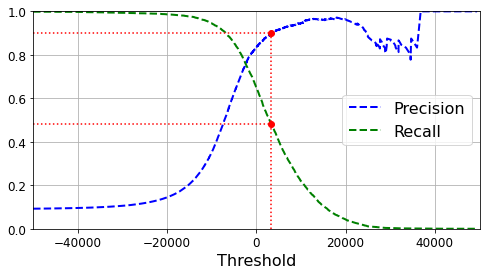

In [29]:
#맷플롯립을 이요해 임곘값의 함수로 정밀도와 재현율을 그릴 수 있음

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall", linewidth=2)
    #임곗값 표시, 범례, 축 이름, 그리드
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])
    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
    
plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show()

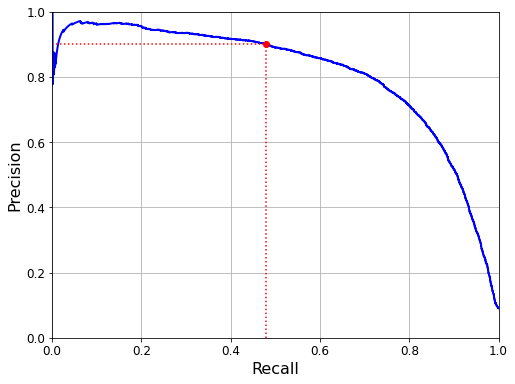

In [30]:
#재현율에 대한 정밀도 곡선

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

#재현율 80% 근처에서 정밀도가 급격하게 줄어듦 -> 이 하강점 직전을 트레이드오프로 선택하는 것이 좋음
#Ex) 재현율 60% 지점

In [31]:
#정밀도 90% 지점 찾기

#np.argmax() = 최댓값의 첫 번쨰 인덱스 반환 -> 여기서는 첫 번째 True 값을 의미
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # ~7816

In [32]:
#예측 만들기
#predict 메서드 대신 다음 코드 실행

y_train_pred_90 = (y_scores >= threshold_90_precision)

In [33]:
#정밀도
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [34]:
#재현율
recall_score(y_train_5, y_train_pred_90)

#가상의 정밀도를 설정하였을 때, 충분히 큰 임곗값을 설정하면 분류기를 손쉽게 만들 수 있음
# **재현율이 너무 낮다면 높은 정밀도의 분류기는 유용하지 않음

0.4799852425751706

In [35]:
#ROC 곡선

#ROC = 수신기(receiver) 조작(operating) 특성(characteristic)
#거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR)의 곡선
#FPR: 1에서 음성으로 정확하게 분류한 음성 샘플의 비율인 진짜 음성 비율(TNR, 특이도)을 뺀 값
# => ROC 곡선: 민감도(재현율)에 대한 1-특이도 그래프

#roc_curve()를 사용해 여러 임곗값에서  TPR과 FPR을 계산

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

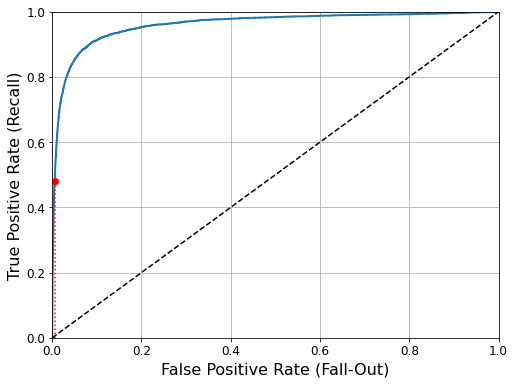

In [36]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)
    
plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.show()

#모든 가능한 임곗값에서 진짜 양성 비율에 대한 거짓 양성 비율을 나타낸 ROC곡선
#붉은 점이 선택한 비율의 지점(47.99%의 재현율)
#트레이드오프 존재(재현율/TPR이 높을수록 분류기가 만드는 거짓 양성/FPR이 늘어남)
#점선: 완전한 랜덤 분류기의 ROC곡선 -> 점선에서 멀리 떨어져있을수록 좋은 분류기(왼쪽 위 모서리)

In [37]:
#곡선(area) 아래의(under the) 면적(curve)/AUC을 측정하면 분류기들을 비교할 수 있음
#완벽한 분류기: ROC의 AUC = 1
#완전한 랜덤 분류기: ROC의 AUC = 0.5

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

#양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때 -> PR곡선 사용 / 그렇지 않으면 ROC 곡선 사용 
#조금 전의 ROC곡선을 보면 매우 좋은 분류기라고 생각할 수 있지만 이는 음성(5 아님)에 비해 양성(5)이 크게 적기 때문
#PR 곡선은 분류기의 성능 개선 여지가 얼마나 되는지(오른쪽 위 모서리에 가까워질 수 있는지) 잘 보여줌

0.9604938554008616

In [38]:
#RandomForestClassifier를 훈련시켜 SGDClassifier의 ROC 곡선과 ROC AUC 점수 비교하기

#1. 훈련 세트의 샘플에 대한 점수 얻기
#decision_function() 대신 predict_proba() 사용
#predict_proba: 샘플이 행, 클래스가 열, 샘플이 주어진 클래스에 속할 확률을 담은 배열 반환(ex: 어떤 이미지가 5일 확률 70%)

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba")

In [39]:
#roc_curve(): 레이블과 점수 기대 / But 점수 대신 클래스 확률을 전달할 수 있음
#양성 클래스 확률을 점수로 사용

y_scores_forest = y_probas_forest[:, -1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

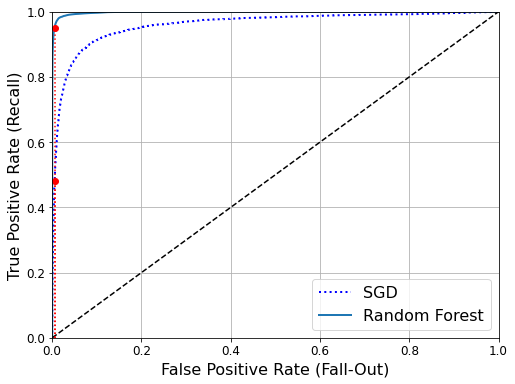

In [40]:
#2. ROC 곡선 그리기

#비교를 위해 첫번째 곡선도 함께 그림

recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

#랜덤 포레스트 분류기가 SGD 분류기보다 훨씬 좋음

In [41]:
roc_auc_score(y_train_5, y_scores_forest)
#ROC AUC 점수도 랜덤 포레스트가 더 좋음
#정밀도: 99.0% / 재현율: 86.6%

0.9983436731328145

In [42]:
#다중 분류

#이진 분류: 두 개의 클래스 구분 / 다중 분류: 둘 이상의 클래스 구별
#여러 개의 클래스를 처리할 수 있는 알고리즘: SGD 분류기, 랜덤 포레스트 분류기, 나이브 베이즈 분류기 등
#두 개의 클래스만 처리할 수 있는 알고리즘: 로지스틱 회귀, 서포트 벡터 머신 분류기

#이진 분류기를 여러 개 사용해서 다중 클래스를 분류할 수도 있음

#OvR(One-versus-the-Rest) 전략: 이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택
#OvO(One-versus-One) 전략: 0과 1 구별, 0과 2 구별, 1과 2 구별 등과 같이 각 숫자의 조합마다 이진 분류기를 훈련시킴

#다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이킷런이 알고리즘에 따라 자동으로 OvR 또는 OvO 실행



#서포드 벡터 머신 분류기 테스트

from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)

#0에서 9까지의 원래 타킷 클래스(y_train)을 사용해 SVC 훈련
svm_clf.fit(X_train[:1000], y_train[:1000]) #y_train_5가 아닌 y_train 사용 (다중 클래스 분류)

#예측 하나를 만듦
svm_clf.predict([some_digit])


#내부에서는 사이킷런의 OvO 전략을 사용해 10개의 이진 분류기를 훈련시키고 각각의 결정 점수를 얻어 점수가 가장 높은 클래스를 선택

array([5], dtype=uint8)

In [43]:
#decision_function()으로 예상한대로 작동하는지 확인하기
#decision_function(): 샘플당 10개의 점수를 반환(클래스마다 하나씩)

some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

#가장 높은 점수가 5에 해당하는 값임

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [44]:
np.argmax(some_digit_scores)

5

In [45]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [46]:
svm_clf.classes_[5]

5

In [47]:
#OvO나 OvR 사용을 강제하려면 OneVsOneClassifier나 OneVsRestClassifier를 사용

#SVC 기반으로 OvR 전략을 사용하는 다중 분류기 만들기

from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [48]:
len(ovr_clf.estimators_)

10

In [49]:
#SGD 훈련시키기

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [50]:
sgd_clf.classes_[3]

3

In [51]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [52]:
#cross_val_score()를 사용해 정확도 평가

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [53]:
#입력 스케일 조정을 통해 정확도 높이기

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [54]:
#에러 분석

#가능성이 높은 모델을 하나 찾았다고 가정하고 이 모델의 성능을 향상시킬 방법 찾기

#1. 오차 행렬 살펴보기
#cross_val_predict()를 사용해 예측을 만들고 confusion_matrix() 호출

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

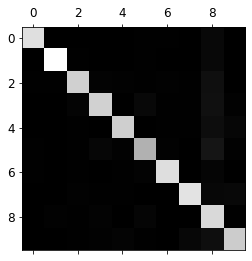

In [55]:
#위 오차행렬 이미지로 표현하기

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

#숫자 5는 다른 숫자보다 조금 더 어두움.
# -> 1. 이미지가 적음 / 2. 숫자 5를 다른 숫자만큼 잘 분류하지 못함
#1, 2 경우에 대해 모두 확인해 봐야함 

In [56]:
#오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율 비교

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

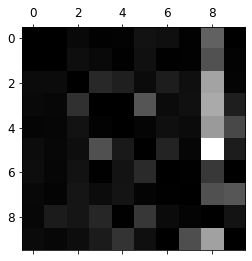

In [57]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

#행: 실제 클래스 / 열: 예측한 클래스

#많은 이미지가 8로 잘못 분류되었음
#3과 5가 서로 많이 혼동되고있음

그림 저장: error_analysis_digits_plot


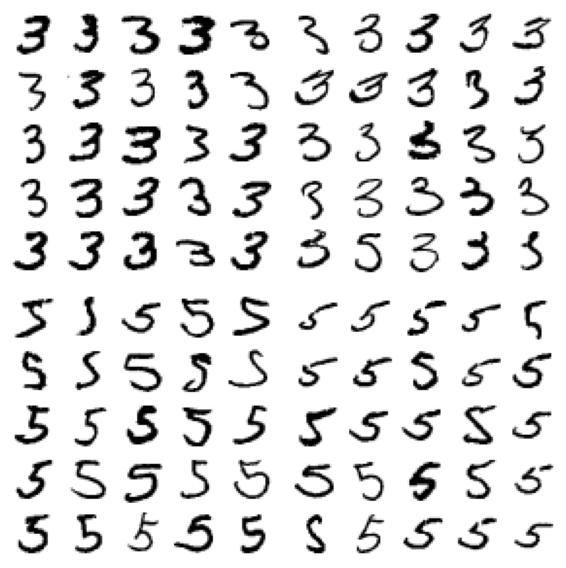

In [58]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

#왼쪽: 3으로 분류된 이미지 / 오른쪽: 5로 분류된 이미지
#선형 모델인 SGD 분류기를 사용했기 때문에 잘못 분류되었음
#선형 분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산한다.
#따라서 3과 5는 몇 개의 픽셀만 다르기 때문에 모델이 쉽게 혼동함
#분류기는 이미지의 위치나 회전 방향에 매우 민감 -> 에러를 줄이기 위해 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리하면 됨

In [60]:
#연습문제

#1

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [{"weights": ["uniform", "distance"], "n_neighbors": [3, 4, 5]}]

knc_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knc_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.972 total time=  12.4s
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.971 total time=  12.3s
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  12.2s
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  12.6s
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.970 total time=  12.3s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  12.1s
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  12.4s
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  12.1s
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  12.6s
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.971 total time=  12.3s
[CV 1/5] END ....n_neighbors=4, weights=uniform;, score=0.969 total time=  14.2s
[CV 2/5] END ....n_neighbors=4, weights=uniform;,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [61]:
grid_search.best_estimator_

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [62]:
grid_search.best_score_

0.9716166666666666

In [63]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

In [69]:
#2(데이터 증식)

from scipy.ndimage.interpolation import shift

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

In [70]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [71]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [72]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

#데이터의 증식으로 정확도가 약 0.5% 높아짐

0.9763